In [45]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [120]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭
nfreq = 1

In [121]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 1 / fcen * 2
monitor_blank = 1 / fcen * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = width_ag + width_sio2 + width_ag
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1  # 평면 구조

# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y, side=mp.Low),
    mp.PML(tpml, direction=mp.Y, side=mp.High)
]

In [122]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [123]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [124]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag]
    )
    for src in sources
]

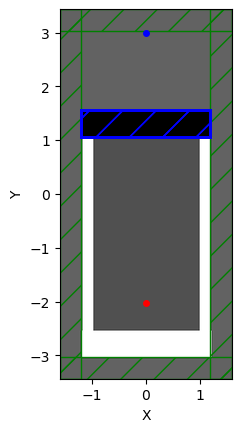

In [125]:
monitor_position_J = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(0, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

def J(fields):
    return npa.sum(npa.real(fields) ** 2) 

def J(fields):
    P_sum = 0.0

    for f in fields:
        arr = npa.atleast_1d(f)
        if arr.ndim >= 2:
            data = arr[0]
        else:
            data = arr
        Ez0 = npa.mean(data)
        P_sum += npa.abs(Ez0)**2

    return P_sum

opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

In [105]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
    
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [106]:
eta_i = 0.5

def multi_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)



--- Iter 1 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.02076986693938792]
Mean FoM: 0.020770
Binarization degree: 0.0000


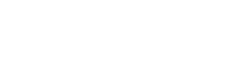


--- Iter 2 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.03268085305867613]
Mean FoM: 0.032681
Binarization degree: 0.0101


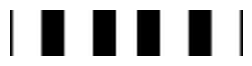


--- Iter 3 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.059736264305428284]
Mean FoM: 0.059736
Binarization degree: 0.0280


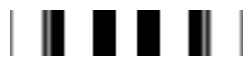


--- Iter 4 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.09887123039100726]
Mean FoM: 0.098871
Binarization degree: 0.0550


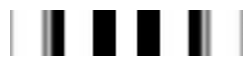


--- Iter 5 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.14348164223152335]
Mean FoM: 0.143482
Binarization degree: 0.0877


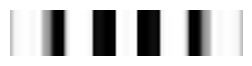


--- Iter 6 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.1908115292689142]
Mean FoM: 0.190812
Binarization degree: 0.1219


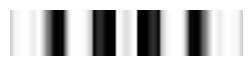


--- Iter 7 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.2192233150882141]
Mean FoM: 0.219223
Binarization degree: 0.1499


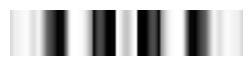


--- Iter 8 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.27540488306727934]
Mean FoM: 0.275405
Binarization degree: 0.1692


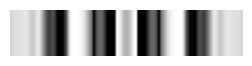


--- Iter 9 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.37401851070007275]
Mean FoM: 0.374019
Binarization degree: 0.1888


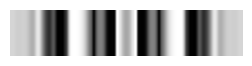


--- Iter 10 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.47585468189014024]
Mean FoM: 0.475855
Binarization degree: 0.2208


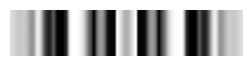


--- Iter 11 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.4981380338470254]
Mean FoM: 0.498138
Binarization degree: 0.2626


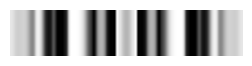


--- Iter 12 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.5786298139772786]
Mean FoM: 0.578630
Binarization degree: 0.2937


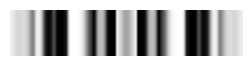


--- Iter 13 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.5498032365434697]
Mean FoM: 0.549803
Binarization degree: 0.3207


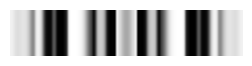


--- Iter 14 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.6290642214838771]
Mean FoM: 0.629064
Binarization degree: 0.3394


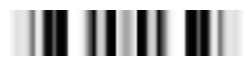


--- Iter 15 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.6419885079337991]
Mean FoM: 0.641989
Binarization degree: 0.3552


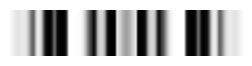


--- Iter 16 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.6517535321110421]
Mean FoM: 0.651754
Binarization degree: 0.3712


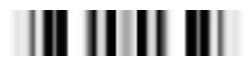


--- Iter 17 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.6770976523853552]
Mean FoM: 0.677098
Binarization degree: 0.3859


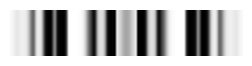


--- Iter 18 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.7329004921723468]
Mean FoM: 0.732900
Binarization degree: 0.3977


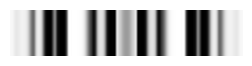


--- Iter 19 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.7337858014148265]
Mean FoM: 0.733786
Binarization degree: 0.4092


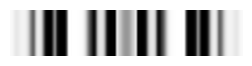


--- Iter 20 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.7726722579761652]
Mean FoM: 0.772672
Binarization degree: 0.4224


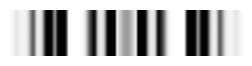


--- Iter 21 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.752953378666605]
Mean FoM: 0.752953
Binarization degree: 0.4346


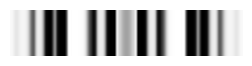


--- Iter 22 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.7780012349465766]
Mean FoM: 0.778001
Binarization degree: 0.4427


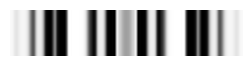


--- Iter 23 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8313512295946859]
Mean FoM: 0.831351
Binarization degree: 0.4498


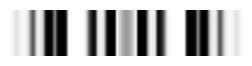


--- Iter 24 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.7830930080544687]
Mean FoM: 0.783093
Binarization degree: 0.4591


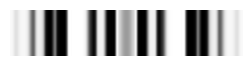


--- Iter 25 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8456519181010679]
Mean FoM: 0.845652
Binarization degree: 0.4669


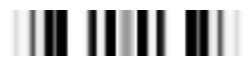


--- Iter 26 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.851518009934593]
Mean FoM: 0.851518
Binarization degree: 0.4762


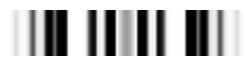


--- Iter 27 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8442873094527273]
Mean FoM: 0.844287
Binarization degree: 0.4845


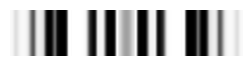


--- Iter 28 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8623845017185384]
Mean FoM: 0.862385
Binarization degree: 0.4922


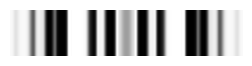


--- Iter 29 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8882112088467073]
Mean FoM: 0.888211
Binarization degree: 0.4992


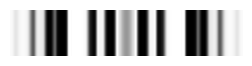


--- Iter 30 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9027379824714914]
Mean FoM: 0.902738
Binarization degree: 0.5050


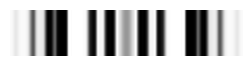


--- Iter 31 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8768838326859015]
Mean FoM: 0.876884
Binarization degree: 0.5103


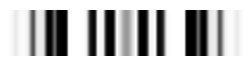


--- Iter 32 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8845337791430902]
Mean FoM: 0.884534
Binarization degree: 0.5173


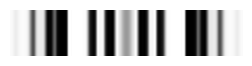


--- Iter 33 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9163579196255236]
Mean FoM: 0.916358
Binarization degree: 0.5245


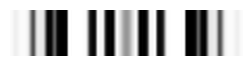


--- Iter 34 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9219171171476901]
Mean FoM: 0.921917
Binarization degree: 0.5316


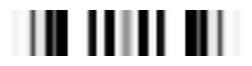


--- Iter 35 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.906481525607273]
Mean FoM: 0.906482
Binarization degree: 0.5379


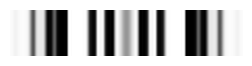


--- Iter 36 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9292499783647526]
Mean FoM: 0.929250
Binarization degree: 0.5429


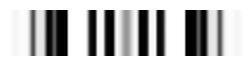


--- Iter 37 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9245737271701104]
Mean FoM: 0.924574
Binarization degree: 0.5474


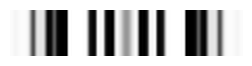


--- Iter 38 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9166997015897025]
Mean FoM: 0.916700
Binarization degree: 0.5516


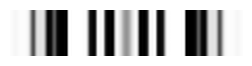


--- Iter 39 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9264226993268039]
Mean FoM: 0.926423
Binarization degree: 0.5552


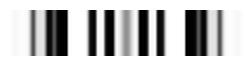


--- Iter 40 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9355303116019068]
Mean FoM: 0.935530
Binarization degree: 0.5584


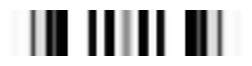


--- Iter 41 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9263955953362587]
Mean FoM: 0.926396
Binarization degree: 0.5616


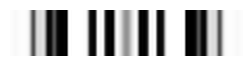


--- Iter 42 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9287116825981204]
Mean FoM: 0.928712
Binarization degree: 0.5645


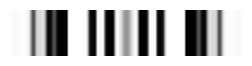


--- Iter 43 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9535109018799061]
Mean FoM: 0.953511
Binarization degree: 0.5672


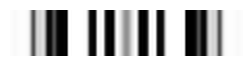


--- Iter 44 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9423581664768287]
Mean FoM: 0.942358
Binarization degree: 0.5698


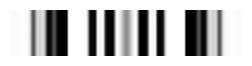


--- Iter 45 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9597762159409488]
Mean FoM: 0.959776
Binarization degree: 0.5710


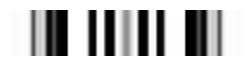


--- Iter 46 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9518034105172929]
Mean FoM: 0.951803
Binarization degree: 0.5721


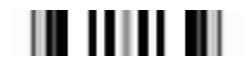


--- Iter 47 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.952670900889539]
Mean FoM: 0.952671
Binarization degree: 0.5732


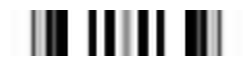


--- Iter 48 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9669656863520213]
Mean FoM: 0.966966
Binarization degree: 0.5745


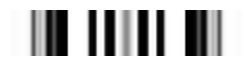


--- Iter 49 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9268992003160561]
Mean FoM: 0.926899
Binarization degree: 0.5769


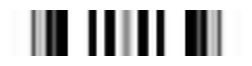


--- Iter 50 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9433039907250226]
Mean FoM: 0.943304
Binarization degree: 0.5790


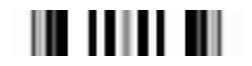


--- Iter 51 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9407818225327359]
Mean FoM: 0.940782
Binarization degree: 0.5812


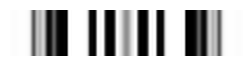


--- Iter 52 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9455452672414106]
Mean FoM: 0.945545
Binarization degree: 0.5838


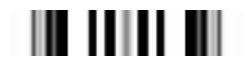


--- Iter 53 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9577874448446712]
Mean FoM: 0.957787
Binarization degree: 0.5866


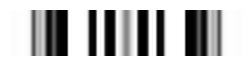


--- Iter 54 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9574705746143899]
Mean FoM: 0.957471
Binarization degree: 0.5885


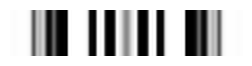


--- Iter 55 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9511462214012123]
Mean FoM: 0.951146
Binarization degree: 0.5907


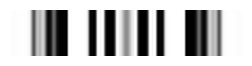


--- Iter 56 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9684387908109515]
Mean FoM: 0.968439
Binarization degree: 0.5933


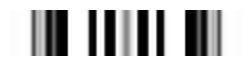


--- Iter 57 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9849676686876166]
Mean FoM: 0.984968
Binarization degree: 0.5954


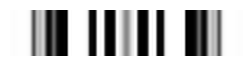


--- Iter 58 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9130657188855338]
Mean FoM: 0.913066
Binarization degree: 0.5975


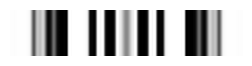


--- Iter 59 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9835719108882024]
Mean FoM: 0.983572
Binarization degree: 0.6004


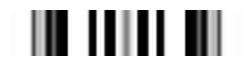


--- Iter 60 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9939846252558919]
Mean FoM: 0.993985
Binarization degree: 0.6026


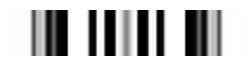


--- Iter 61 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9084023906962985]
Mean FoM: 0.908402
Binarization degree: 0.6042


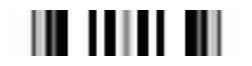


--- Iter 62 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9985754483134096]
Mean FoM: 0.998575
Binarization degree: 0.6067


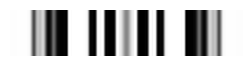


--- Iter 63 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9972774831214395]
Mean FoM: 0.997277
Binarization degree: 0.6087


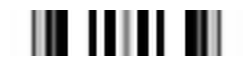


--- Iter 64 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9660605401797117]
Mean FoM: 0.966061
Binarization degree: 0.6100


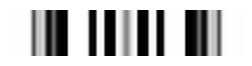


--- Iter 65 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9837358053562149]
Mean FoM: 0.983736
Binarization degree: 0.6115


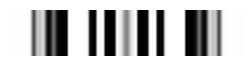


--- Iter 66 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0031759844155483]
Mean FoM: 1.003176
Binarization degree: 0.6132


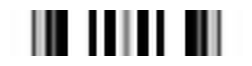


--- Iter 67 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0029007992955739]
Mean FoM: 1.002901
Binarization degree: 0.6141


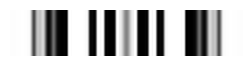


--- Iter 68 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9566390380867104]
Mean FoM: 0.956639
Binarization degree: 0.6147


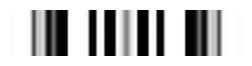


--- Iter 69 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0094290218846849]
Mean FoM: 1.009429
Binarization degree: 0.6159


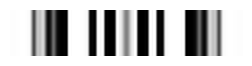


--- Iter 70 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0101263314954865]
Mean FoM: 1.010126
Binarization degree: 0.6167


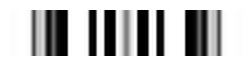


--- Iter 71 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9773157276535096]
Mean FoM: 0.977316
Binarization degree: 0.6168


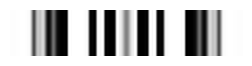


--- Iter 72 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9975382237067426]
Mean FoM: 0.997538
Binarization degree: 0.6173


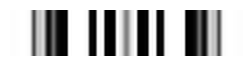


--- Iter 73 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0096011963541889]
Mean FoM: 1.009601
Binarization degree: 0.6179


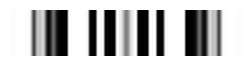


--- Iter 74 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0035746517867954]
Mean FoM: 1.003575
Binarization degree: 0.6180


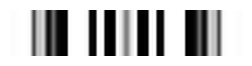


--- Iter 75 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9799401885145076]
Mean FoM: 0.979940
Binarization degree: 0.6179


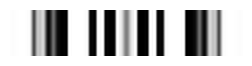


--- Iter 76 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0128999243866634]
Mean FoM: 1.012900
Binarization degree: 0.6187


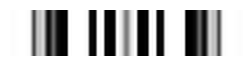


--- Iter 77 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0121028673057004]
Mean FoM: 1.012103
Binarization degree: 0.6188


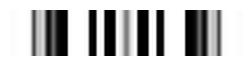


--- Iter 78 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9819259613527336]
Mean FoM: 0.981926
Binarization degree: 0.6185


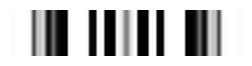


--- Iter 79 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0104352161798587]
Mean FoM: 1.010435
Binarization degree: 0.6192


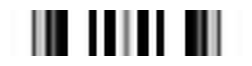


--- Iter 80 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.014704444789167]
Mean FoM: 1.014704
Binarization degree: 0.6196


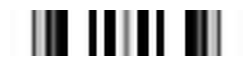


--- Iter 81 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9932353345720248]
Mean FoM: 0.993235
Binarization degree: 0.6196


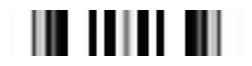


--- Iter 82 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0061822651084686]
Mean FoM: 1.006182
Binarization degree: 0.6201


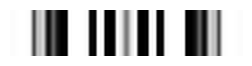


--- Iter 83 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0147198928095593]
Mean FoM: 1.014720
Binarization degree: 0.6207


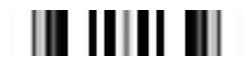


--- Iter 84 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0010828272564045]
Mean FoM: 1.001083
Binarization degree: 0.6207


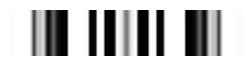


--- Iter 85 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0007960556232895]
Mean FoM: 1.000796
Binarization degree: 0.6212


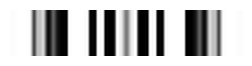


--- Iter 86 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0140742264101954]
Mean FoM: 1.014074
Binarization degree: 0.6219


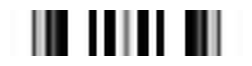


--- Iter 87 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0053083923411512]
Mean FoM: 1.005308
Binarization degree: 0.6222


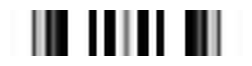


--- Iter 88 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9988056037807419]
Mean FoM: 0.998806
Binarization degree: 0.6225


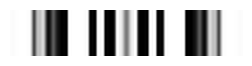


--- Iter 89 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0138725089731067]
Mean FoM: 1.013873
Binarization degree: 0.6232


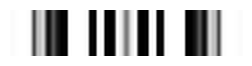


--- Iter 90 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0077393542076292]
Mean FoM: 1.007739
Binarization degree: 0.6235


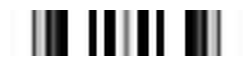


--- Iter 91 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9984622330196061]
Mean FoM: 0.998462
Binarization degree: 0.6237


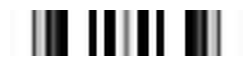


--- Iter 92 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.014713325420357]
Mean FoM: 1.014713
Binarization degree: 0.6244


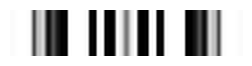


--- Iter 93 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0093091289583962]
Mean FoM: 1.009309
Binarization degree: 0.6246


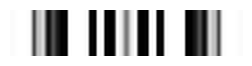


--- Iter 94 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9989518998849082]
Mean FoM: 0.998952
Binarization degree: 0.6246


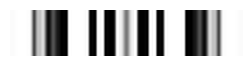


--- Iter 95 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.014853185560652]
Mean FoM: 1.014853
Binarization degree: 0.6251


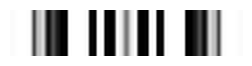


--- Iter 96 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0097078879269656]
Mean FoM: 1.009708
Binarization degree: 0.6250


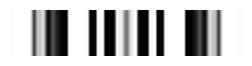


--- Iter 97 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9997885233313546]
Mean FoM: 0.999789
Binarization degree: 0.6249


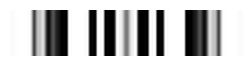


--- Iter 98 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0164043463696584]
Mean FoM: 1.016404
Binarization degree: 0.6254


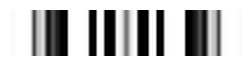


--- Iter 99 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0103469572156212]
Mean FoM: 1.010347
Binarization degree: 0.6252


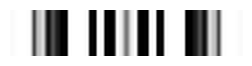


--- Iter 100 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0023523569470694]
Mean FoM: 1.002352
Binarization degree: 0.6251


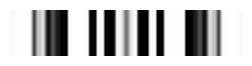


--- Iter 101 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0181034754184497]
Mean FoM: 1.018103
Binarization degree: 0.6256


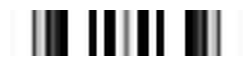


--- Iter 102 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0114835524076786]
Mean FoM: 1.011484
Binarization degree: 0.6256


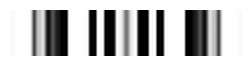


--- Iter 103 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.005077136433567]
Mean FoM: 1.005077
Binarization degree: 0.6257


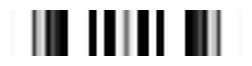


--- Iter 104 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0202540550967714]
Mean FoM: 1.020254
Binarization degree: 0.6263


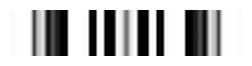


--- Iter 105 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0115753416607316]
Mean FoM: 1.011575
Binarization degree: 0.6263


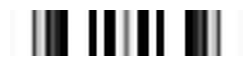


--- Iter 106 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.007988713898267]
Mean FoM: 1.007989
Binarization degree: 0.6265


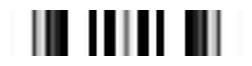


--- Iter 107 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0213203444023589]
Mean FoM: 1.021320
Binarization degree: 0.6273


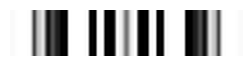


--- Iter 108 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0115732281870558]
Mean FoM: 1.011573
Binarization degree: 0.6273


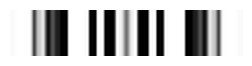


--- Iter 109 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0116946962249924]
Mean FoM: 1.011695
Binarization degree: 0.6277


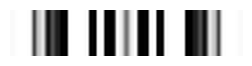


--- Iter 110 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0226847613285197]
Mean FoM: 1.022685
Binarization degree: 0.6284


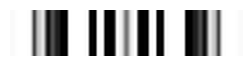


--- Iter 111 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.01185832140209]
Mean FoM: 1.011858
Binarization degree: 0.6284


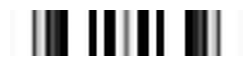


--- Iter 112 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.017005346262508]
Mean FoM: 1.017005
Binarization degree: 0.6288


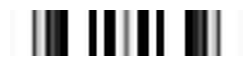


--- Iter 113 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0237711978192152]
Mean FoM: 1.023771
Binarization degree: 0.6292


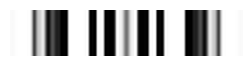


--- Iter 114 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0129414868604636]
Mean FoM: 1.012941
Binarization degree: 0.6292


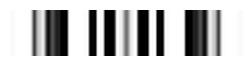


--- Iter 115 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.023742375259449]
Mean FoM: 1.023742
Binarization degree: 0.6295


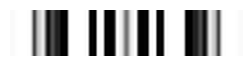


--- Iter 116 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.022434443010299]
Mean FoM: 1.022434
Binarization degree: 0.6295


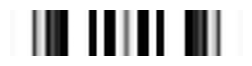


--- Iter 117 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0173668022976228]
Mean FoM: 1.017367
Binarization degree: 0.6294


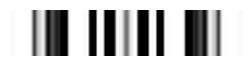


--- Iter 118 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0294294853462664]
Mean FoM: 1.029429
Binarization degree: 0.6295


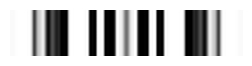


--- Iter 119 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0152158323959406]
Mean FoM: 1.015216
Binarization degree: 0.6292


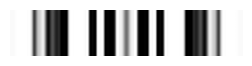


--- Iter 120 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0325106303590368]
Mean FoM: 1.032511
Binarization degree: 0.6294


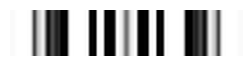


--- Iter 121 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.014111826779553]
Mean FoM: 1.014112
Binarization degree: 0.6292


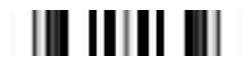


--- Iter 122 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0366820677083681]
Mean FoM: 1.036682
Binarization degree: 0.6296


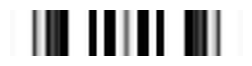


--- Iter 123 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0049433838891717]
Mean FoM: 1.004943
Binarization degree: 0.6294


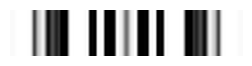


--- Iter 124 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.040864940892853]
Mean FoM: 1.040865
Binarization degree: 0.6304


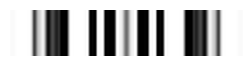


--- Iter 125 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.000286651690589]
Mean FoM: 1.000287
Binarization degree: 0.6301


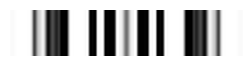


--- Iter 126 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0426213621493936]
Mean FoM: 1.042621
Binarization degree: 0.6313


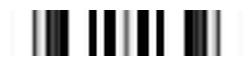


--- Iter 127 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0259376689088067]
Mean FoM: 1.025938
Binarization degree: 0.6315


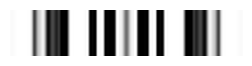


--- Iter 128 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0269858909028604]
Mean FoM: 1.026986
Binarization degree: 0.6319


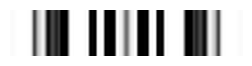


--- Iter 129 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0461441968460417]
Mean FoM: 1.046144
Binarization degree: 0.6324


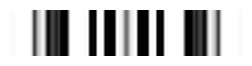


--- Iter 130 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0110763807399545]
Mean FoM: 1.011076
Binarization degree: 0.6324


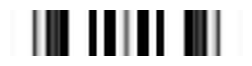


--- Iter 131 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0478457124094955]
Mean FoM: 1.047846
Binarization degree: 0.6330


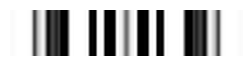


--- Iter 132 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0288274851146524]
Mean FoM: 1.028827
Binarization degree: 0.6330


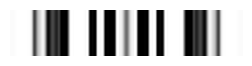


--- Iter 133 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0348520657362545]
Mean FoM: 1.034852
Binarization degree: 0.6333


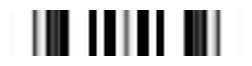


--- Iter 134 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0493803767477983]
Mean FoM: 1.049380
Binarization degree: 0.6336


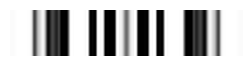


--- Iter 135 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.017621177384966]
Mean FoM: 1.017621
Binarization degree: 0.6335


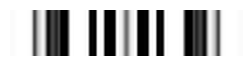


--- Iter 136 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.053361483734045]
Mean FoM: 1.053361
Binarization degree: 0.6339


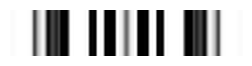


--- Iter 137 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0277988751073674]
Mean FoM: 1.027799
Binarization degree: 0.6338


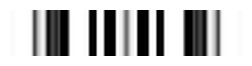


--- Iter 138 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0467252635441084]
Mean FoM: 1.046725
Binarization degree: 0.6342


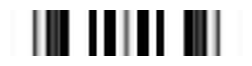


--- Iter 139 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0498157758585622]
Mean FoM: 1.049816
Binarization degree: 0.6345


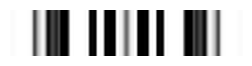


--- Iter 140 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0293722366236082]
Mean FoM: 1.029372
Binarization degree: 0.6346


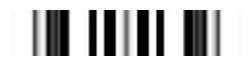


--- Iter 141 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0576036327718548]
Mean FoM: 1.057604
Binarization degree: 0.6351


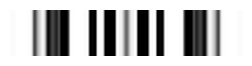


--- Iter 142 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0281472570093801]
Mean FoM: 1.028147
Binarization degree: 0.6350


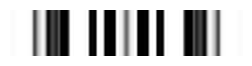


--- Iter 143 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0569133063812544]
Mean FoM: 1.056913
Binarization degree: 0.6357


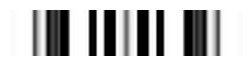


--- Iter 144 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.04777724924909]
Mean FoM: 1.047777
Binarization degree: 0.6360


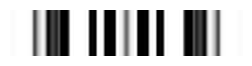


--- Iter 145 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.045395606059472]
Mean FoM: 1.045396
Binarization degree: 0.6364


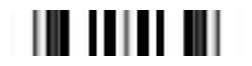


--- Iter 146 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0610127871175086]
Mean FoM: 1.061013
Binarization degree: 0.6368


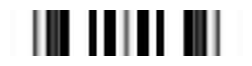


--- Iter 147 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0364836075893549]
Mean FoM: 1.036484
Binarization degree: 0.6368


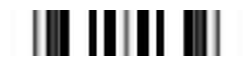


--- Iter 148 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0629737800983956]
Mean FoM: 1.062974
Binarization degree: 0.6373


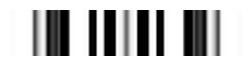


--- Iter 149 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.045944077190752]
Mean FoM: 1.045944
Binarization degree: 0.6375


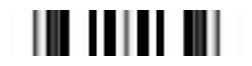


--- Iter 150 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0573162677318624]
Mean FoM: 1.057316
Binarization degree: 0.6378


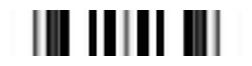


--- Iter 151 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.060208116615943]
Mean FoM: 1.060208
Binarization degree: 0.6384


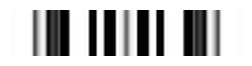


--- Iter 152 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0475839074253366]
Mean FoM: 1.047584
Binarization degree: 0.6387


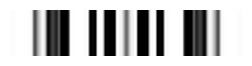


--- Iter 153 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0665405339044305]
Mean FoM: 1.066541
Binarization degree: 0.6397


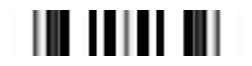


--- Iter 154 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0463719431977054]
Mean FoM: 1.046372
Binarization degree: 0.6398


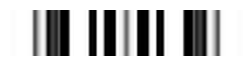


--- Iter 155 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0673340185712092]
Mean FoM: 1.067334
Binarization degree: 0.6408


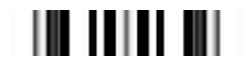


--- Iter 156 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0546092419370694]
Mean FoM: 1.054609
Binarization degree: 0.6410


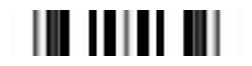


--- Iter 157 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0632373111482434]
Mean FoM: 1.063237
Binarization degree: 0.6416


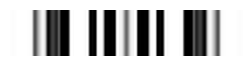


--- Iter 158 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0637063068369756]
Mean FoM: 1.063706
Binarization degree: 0.6422


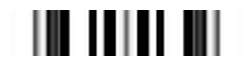


--- Iter 159 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0581607475417831]
Mean FoM: 1.058161
Binarization degree: 0.6428


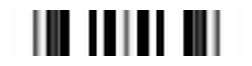


--- Iter 160 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.070312345367561]
Mean FoM: 1.070312
Binarization degree: 0.6436


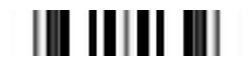


--- Iter 161 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0552695075593954]
Mean FoM: 1.055270
Binarization degree: 0.6439


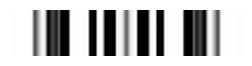


--- Iter 162 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0737859740786606]
Mean FoM: 1.073786
Binarization degree: 0.6448


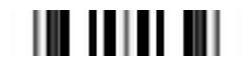


--- Iter 163 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.056063139265499]
Mean FoM: 1.056063
Binarization degree: 0.6450


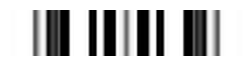


--- Iter 164 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0757633551184922]
Mean FoM: 1.075763
Binarization degree: 0.6459


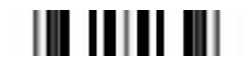


--- Iter 165 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0605885459075923]
Mean FoM: 1.060589
Binarization degree: 0.6461


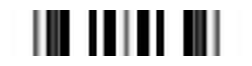


--- Iter 166 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.076054841567014]
Mean FoM: 1.076055
Binarization degree: 0.6469


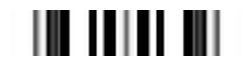


--- Iter 167 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0652560140290064]
Mean FoM: 1.065256
Binarization degree: 0.6471


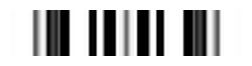


--- Iter 168 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0753924559213475]
Mean FoM: 1.075392
Binarization degree: 0.6481


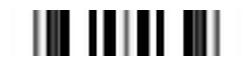


--- Iter 169 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0696578647214472]
Mean FoM: 1.069658
Binarization degree: 0.6490


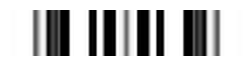


--- Iter 170 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0756696621884942]
Mean FoM: 1.075670
Binarization degree: 0.6500


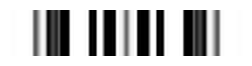


--- Iter 171 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0730630294247667]
Mean FoM: 1.073063
Binarization degree: 0.6509


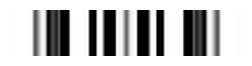


--- Iter 172 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0762544676685617]
Mean FoM: 1.076254
Binarization degree: 0.6519


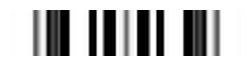


--- Iter 173 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0754357852380287]
Mean FoM: 1.075436
Binarization degree: 0.6529


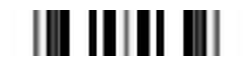


--- Iter 174 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0777648168005542]
Mean FoM: 1.077765
Binarization degree: 0.6539


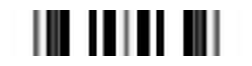


--- Iter 175 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0776273051584464]
Mean FoM: 1.077627
Binarization degree: 0.6548


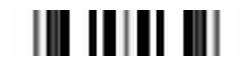


--- Iter 176 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0796145619556472]
Mean FoM: 1.079615
Binarization degree: 0.6558


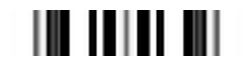


--- Iter 177 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0790072677272737]
Mean FoM: 1.079007
Binarization degree: 0.6567


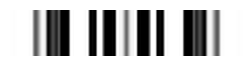


--- Iter 178 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0820863817737933]
Mean FoM: 1.082086
Binarization degree: 0.6577


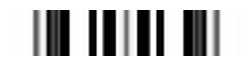


--- Iter 179 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0802928852890792]
Mean FoM: 1.080293
Binarization degree: 0.6586


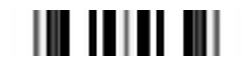


--- Iter 180 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0863990476195795]
Mean FoM: 1.086399
Binarization degree: 0.6596


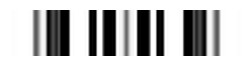


--- Iter 181 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0789286156142608]
Mean FoM: 1.078929
Binarization degree: 0.6604


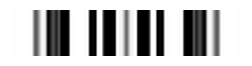


--- Iter 182 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.092592883704425]
Mean FoM: 1.092593
Binarization degree: 0.6615


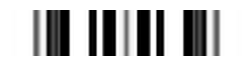


--- Iter 183 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.066292274927647]
Mean FoM: 1.066292
Binarization degree: 0.6619


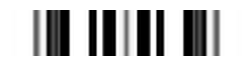


--- Iter 184 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0958025658212156]
Mean FoM: 1.095803
Binarization degree: 0.6644


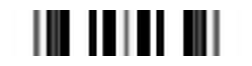


--- Iter 185 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0340359348487902]
Mean FoM: 1.034036
Binarization degree: 0.6638


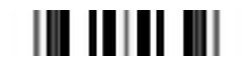


--- Iter 186 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.080719646150342]
Mean FoM: 1.080720
Binarization degree: 0.6676


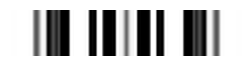


--- Iter 187 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0859419362262832]
Mean FoM: 1.085942
Binarization degree: 0.6674


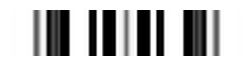


--- Iter 188 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0196107732397843]
Mean FoM: 1.019611
Binarization degree: 0.6678


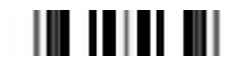


--- Iter 189 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0372541920521294]
Mean FoM: 1.037254
Binarization degree: 0.6729


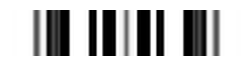


--- Iter 190 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0775668001510224]
Mean FoM: 1.077567
Binarization degree: 0.6737


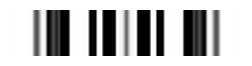


--- Iter 191 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.8681312333475117]
Mean FoM: 0.868131
Binarization degree: 0.6715


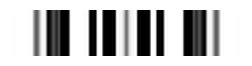


--- Iter 192 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0856793691003925]
Mean FoM: 1.085679
Binarization degree: 0.6774


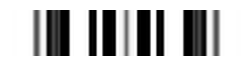


--- Iter 193 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.050438176539678]
Mean FoM: 1.050438
Binarization degree: 0.6804


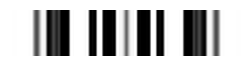


--- Iter 194 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1051423690717976]
Mean FoM: 1.105142
Binarization degree: 0.6806


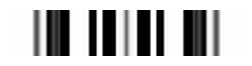


--- Iter 195 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9027876877579487]
Mean FoM: 0.902788
Binarization degree: 0.6800


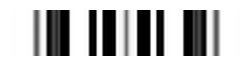


--- Iter 196 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1062183385578175]
Mean FoM: 1.106218
Binarization degree: 0.6851


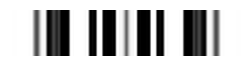


--- Iter 197 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0624239285460817]
Mean FoM: 1.062424
Binarization degree: 0.6878


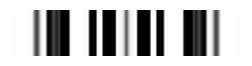


--- Iter 198 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1100268271887583]
Mean FoM: 1.110027
Binarization degree: 0.6881


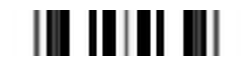


--- Iter 199 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [0.9567915665431108]
Mean FoM: 0.956792
Binarization degree: 0.6868


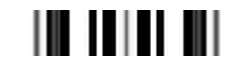


--- Iter 200 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.107111483914245]
Mean FoM: 1.107111
Binarization degree: 0.6901


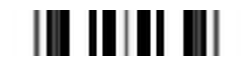


--- Iter 201 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.097927649685475]
Mean FoM: 1.097928
Binarization degree: 0.6927


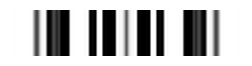


--- Iter 202 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1181304764641573]
Mean FoM: 1.118130
Binarization degree: 0.6930


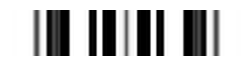


--- Iter 203 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0216036695695303]
Mean FoM: 1.021604
Binarization degree: 0.6918


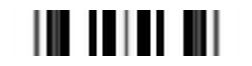


--- Iter 204 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0984655242428853]
Mean FoM: 1.098466
Binarization degree: 0.6937


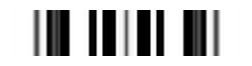


--- Iter 205 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.111342594796086]
Mean FoM: 1.111343
Binarization degree: 0.6958


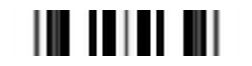


--- Iter 206 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1138322097517828]
Mean FoM: 1.113832
Binarization degree: 0.6960


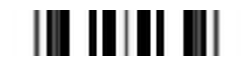


--- Iter 207 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0427196692941558]
Mean FoM: 1.042720
Binarization degree: 0.6949


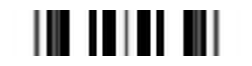


--- Iter 208 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0949267867533863]
Mean FoM: 1.094927
Binarization degree: 0.6965


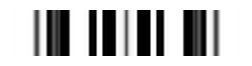


--- Iter 209 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1152898923069396]
Mean FoM: 1.115290
Binarization degree: 0.6983


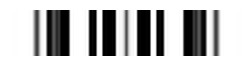


--- Iter 210 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1149765530173565]
Mean FoM: 1.114977
Binarization degree: 0.6985


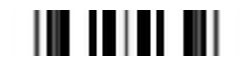


--- Iter 211 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0585791258282748]
Mean FoM: 1.058579
Binarization degree: 0.6978


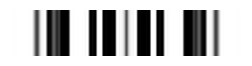


--- Iter 212 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1043786291907691]
Mean FoM: 1.104379
Binarization degree: 0.6993


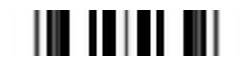


--- Iter 213 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1170009853721947]
Mean FoM: 1.117001
Binarization degree: 0.7007


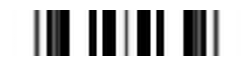


--- Iter 214 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.110512874599698]
Mean FoM: 1.110513
Binarization degree: 0.7007


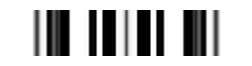


--- Iter 215 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.071170757643506]
Mean FoM: 1.071171
Binarization degree: 0.7003


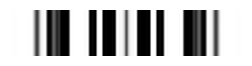


--- Iter 216 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1085297976434874]
Mean FoM: 1.108530
Binarization degree: 0.7016


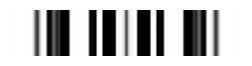


--- Iter 217 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1204907036112994]
Mean FoM: 1.120491
Binarization degree: 0.7026


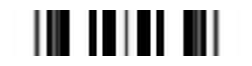


--- Iter 218 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.111510035658519]
Mean FoM: 1.111510
Binarization degree: 0.7024


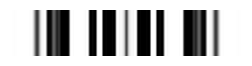


--- Iter 219 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.0829037774726644]
Mean FoM: 1.082904
Binarization degree: 0.7021


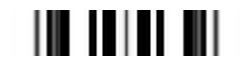


--- Iter 220 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1137660673885714]
Mean FoM: 1.113766
Binarization degree: 0.7030


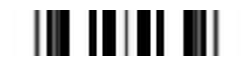


--- Iter 221 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1199855533627336]
Mean FoM: 1.119986
Binarization degree: 0.7036


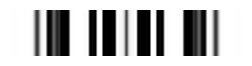


--- Iter 222 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.105672382745224]
Mean FoM: 1.105672
Binarization degree: 0.7032


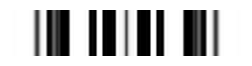


--- Iter 223 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.089326600075333]
Mean FoM: 1.089327
Binarization degree: 0.7030


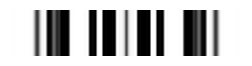


--- Iter 224 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1158477839068817]
Mean FoM: 1.115848
Binarization degree: 0.7038


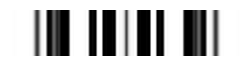


--- Iter 225 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1198692864389435]
Mean FoM: 1.119869
Binarization degree: 0.7043


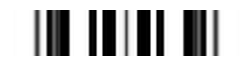


--- Iter 226 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1025289728166419]
Mean FoM: 1.102529
Binarization degree: 0.7046


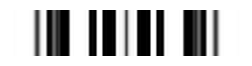


--- Iter 227 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.100287867005202]
Mean FoM: 1.100288
Binarization degree: 0.7050


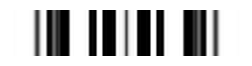


--- Iter 228 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1194998995022114]
Mean FoM: 1.119500
Binarization degree: 0.7058


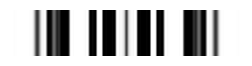


--- Iter 229 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1178360824166174]
Mean FoM: 1.117836
Binarization degree: 0.7062


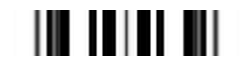


--- Iter 230 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.099704095829895]
Mean FoM: 1.099704
Binarization degree: 0.7065


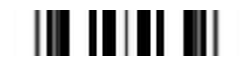


--- Iter 231 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1099088159833372]
Mean FoM: 1.109909
Binarization degree: 0.7071


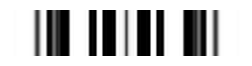


--- Iter 232 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.121209623981548]
Mean FoM: 1.121210
Binarization degree: 0.7077


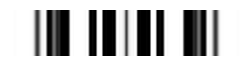


--- Iter 233 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1147615057890414]
Mean FoM: 1.114762
Binarization degree: 0.7081


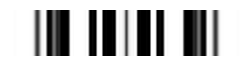


--- Iter 234 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1036940051389985]
Mean FoM: 1.103694
Binarization degree: 0.7084


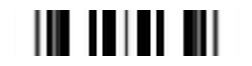


--- Iter 235 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1185331850765217]
Mean FoM: 1.118533
Binarization degree: 0.7090


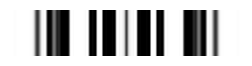


--- Iter 236 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1210162884457835]
Mean FoM: 1.121016
Binarization degree: 0.7094


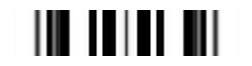


--- Iter 237 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1085109316944015]
Mean FoM: 1.108511
Binarization degree: 0.7096


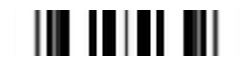


--- Iter 238 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1105660501052899]
Mean FoM: 1.110566
Binarization degree: 0.7100


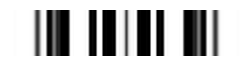


--- Iter 239 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1204850442804941]
Mean FoM: 1.120485
Binarization degree: 0.7105


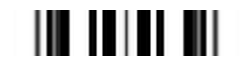


--- Iter 240 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1156835206778022]
Mean FoM: 1.115684
Binarization degree: 0.7108


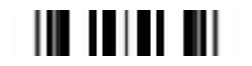


--- Iter 241 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1074904401446894]
Mean FoM: 1.107490
Binarization degree: 0.7111


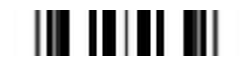


--- Iter 242 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1186559707509875]
Mean FoM: 1.118656
Binarization degree: 0.7116


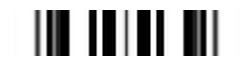


--- Iter 243 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1198618366921846]
Mean FoM: 1.119862
Binarization degree: 0.7120


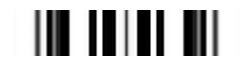


--- Iter 244 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1101358184568422]
Mean FoM: 1.110136
Binarization degree: 0.7123


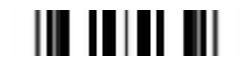


--- Iter 245 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1156304199080178]
Mean FoM: 1.115630
Binarization degree: 0.7127


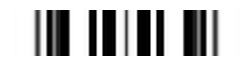


--- Iter 246 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1210237084205645]
Mean FoM: 1.121024
Binarization degree: 0.7131


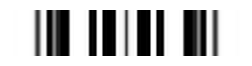


--- Iter 247 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1145511378912978]
Mean FoM: 1.114551
Binarization degree: 0.7134


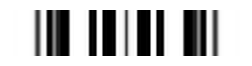


--- Iter 248 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1142161469212788]
Mean FoM: 1.114216
Binarization degree: 0.7138


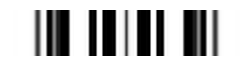


--- Iter 249 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1220824399553453]
Mean FoM: 1.122082
Binarization degree: 0.7143


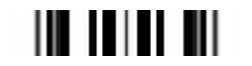


--- Iter 250 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.119293057195194]
Mean FoM: 1.119293
Binarization degree: 0.7146


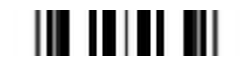


--- Iter 251 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1152757168001883]
Mean FoM: 1.115276
Binarization degree: 0.7149


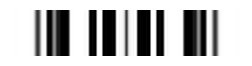


--- Iter 252 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1226630426112136]
Mean FoM: 1.122663
Binarization degree: 0.7153


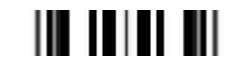


--- Iter 253 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1223011095465014]
Mean FoM: 1.122301
Binarization degree: 0.7157


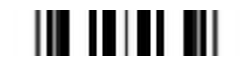


--- Iter 254 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1169260846030102]
Mean FoM: 1.116926
Binarization degree: 0.7159


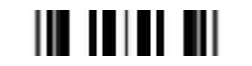


--- Iter 255 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1224096652139302]
Mean FoM: 1.122410
Binarization degree: 0.7163


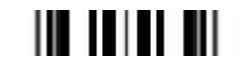


--- Iter 256 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1240526778271018]
Mean FoM: 1.124053
Binarization degree: 0.7166


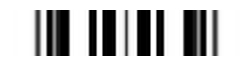


--- Iter 257 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1192135892092328]
Mean FoM: 1.119214
Binarization degree: 0.7168


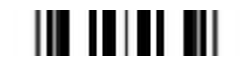


--- Iter 258 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.122657167085579]
Mean FoM: 1.122657
Binarization degree: 0.7171


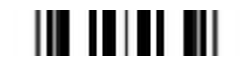


--- Iter 259 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.125565006244645]
Mean FoM: 1.125565
Binarization degree: 0.7174


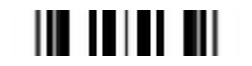


--- Iter 260 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.121636363805411]
Mean FoM: 1.121636
Binarization degree: 0.7176


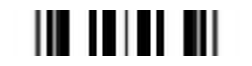


--- Iter 261 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1231143251879423]
Mean FoM: 1.123114
Binarization degree: 0.7180


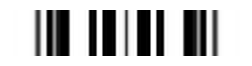


--- Iter 262 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1264915987517512]
Mean FoM: 1.126492
Binarization degree: 0.7184


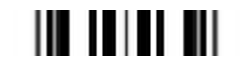


--- Iter 263 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 5.000
FoM values: [1.1235972059916495]
Mean FoM: 1.123597
Binarization degree: 0.7188


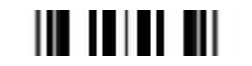


--- Iter 264 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.123841366162883]
Mean FoM: 1.123841
Binarization degree: 0.7192


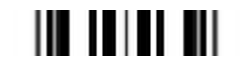


--- Iter 265 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.9341964981009283]
Mean FoM: 0.934196
Binarization degree: 0.7837


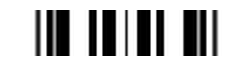


--- Iter 266 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.9832900060526959]
Mean FoM: 0.983290
Binarization degree: 0.7847


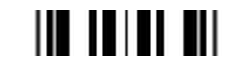


--- Iter 267 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0870636490431087]
Mean FoM: 1.087064
Binarization degree: 0.7843


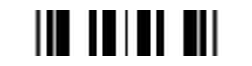


--- Iter 268 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1054562757016586]
Mean FoM: 1.105456
Binarization degree: 0.7836


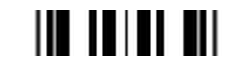


--- Iter 269 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0010466684381454]
Mean FoM: 1.001047
Binarization degree: 0.7828


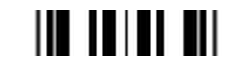


--- Iter 270 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0517628084817137]
Mean FoM: 1.051763
Binarization degree: 0.7812


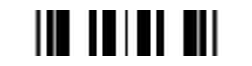


--- Iter 271 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1276149699599471]
Mean FoM: 1.127615
Binarization degree: 0.7802


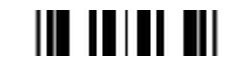


--- Iter 272 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [0.6878874148837478]
Mean FoM: 0.687887
Binarization degree: 0.7805


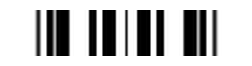


--- Iter 273 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1455762727525534]
Mean FoM: 1.145576
Binarization degree: 0.7792


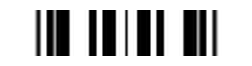


--- Iter 274 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0780047349720359]
Mean FoM: 1.078005
Binarization degree: 0.7792


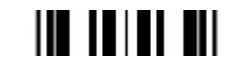


--- Iter 275 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0855652668276612]
Mean FoM: 1.085565
Binarization degree: 0.7792


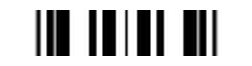


--- Iter 276 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0258431172632778]
Mean FoM: 1.025843
Binarization degree: 0.7806


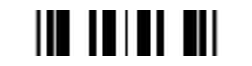


--- Iter 277 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1454831356388844]
Mean FoM: 1.145483
Binarization degree: 0.7844


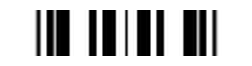


--- Iter 278 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1696287650565387]
Mean FoM: 1.169629
Binarization degree: 0.7883


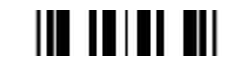


--- Iter 279 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1330340911306598]
Mean FoM: 1.133034
Binarization degree: 0.7919


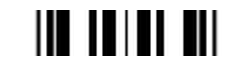


--- Iter 280 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1035510540296236]
Mean FoM: 1.103551
Binarization degree: 0.7947


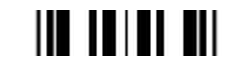


--- Iter 281 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1381222511081854]
Mean FoM: 1.138122
Binarization degree: 0.7967


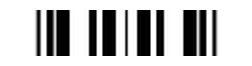


--- Iter 282 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1342933842097638]
Mean FoM: 1.134293
Binarization degree: 0.7983


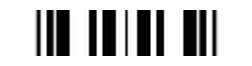


--- Iter 283 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.105802425890772]
Mean FoM: 1.105802
Binarization degree: 0.7996


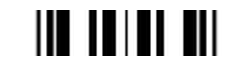


--- Iter 284 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.0972193156880137]
Mean FoM: 1.097219
Binarization degree: 0.8005


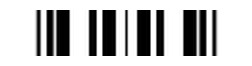


--- Iter 285 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1316348951951545]
Mean FoM: 1.131635
Binarization degree: 0.8014


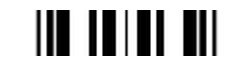


--- Iter 286 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1477179690778458]
Mean FoM: 1.147718
Binarization degree: 0.8018


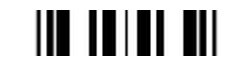


--- Iter 287 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.144502774840888]
Mean FoM: 1.144503
Binarization degree: 0.8015


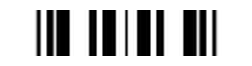


--- Iter 288 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1309656151465923]
Mean FoM: 1.130966
Binarization degree: 0.8011


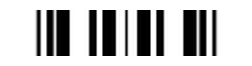


--- Iter 289 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.14822005779513]
Mean FoM: 1.148220
Binarization degree: 0.8013


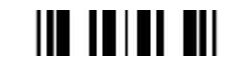


--- Iter 290 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.156750255911802]
Mean FoM: 1.156750
Binarization degree: 0.8020


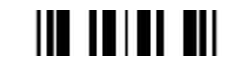


--- Iter 291 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1548020147198819]
Mean FoM: 1.154802
Binarization degree: 0.8027


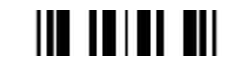


--- Iter 292 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1410278582969544]
Mean FoM: 1.141028
Binarization degree: 0.8036


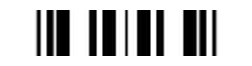


--- Iter 293 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1428412923589357]
Mean FoM: 1.142841
Binarization degree: 0.8049


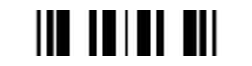


--- Iter 294 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1543747748340354]
Mean FoM: 1.154375
Binarization degree: 0.8064


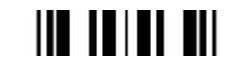


--- Iter 295 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1534857441014696]
Mean FoM: 1.153486
Binarization degree: 0.8074


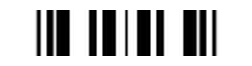


--- Iter 296 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1435171889013895]
Mean FoM: 1.143517
Binarization degree: 0.8080


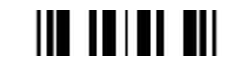


--- Iter 297 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.133527606991889]
Mean FoM: 1.133528
Binarization degree: 0.8085


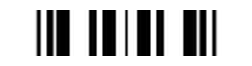


--- Iter 298 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1395479290396044]
Mean FoM: 1.139548
Binarization degree: 0.8086


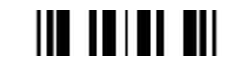


--- Iter 299 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1533290362317163]
Mean FoM: 1.153329
Binarization degree: 0.8084


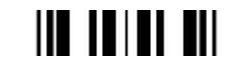


--- Iter 300 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 6.500
FoM values: [1.1598305418516694]
Mean FoM: 1.159831
Binarization degree: 0.8081


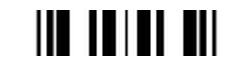

In [115]:
import os
import imageio

n = Nx * layer_num
np.random.seed(5)
# x = 0.4 + 0.2 * np.random.rand(n)  
x = np.ones(n)*0.5

frames_dir = "frames"
os.makedirs(frames_dir, exist_ok=True)

# 저장된 프레임 파일명 리스트
frame_files = []

cur_beta = 5

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    rho_full = multi_mapping(v, eta, beta)

    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny
    rho_list = [rho_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]

    f0_list = []
    dJ_list = []
    for i in range(len(opt_list)):
        f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
        f0_list.append(f0_i.flatten())
        dJ_list.append(dJ_i)

    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    gradient_full = tensor_jacobian_product(multi_mapping, 0)(v, eta, beta, dJ_flat)

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)
    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        # FoM 기준 변화율 계산 (여기 부분 계속 수정중)
        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.003 and change2 < 0.003) and (bin_change1 < 0.001 and bin_change2 < 0.00075):
            if beta < 8:
                beta *= 1.3
            else:
                beta = beta + 5*np.tanh((beta - 0.5)*0.03)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")

    print(f"Binarization degree: {bin_deg:.4f}")
    fig = plt.figure(figsize=(3, 2))

    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    # 2) 프레임으로 저장하기
    frame_filename = os.path.join(frames_dir, f"frame_{cur_iter[0]:03d}.png")
    fig.savefig(frame_filename, dpi=150, bbox_inches='tight')
    plt.close(fig)
    frame_files.append(frame_filename)

    return v_new, beta

mp.verbosity(0)
Max_iter = 300

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.95:
        print("Threshold reached → final mapping with β=∞")
        x, _ = f_multi(x, eta_i, np.inf)
        print("FOM increases : ", )
        break



In [118]:
video_filename = 'optimization_video.mp4'
with imageio.get_writer(video_filename, fps=5, codec='libx264') as writer:
    for filename in frame_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"동영상 생성 완료: {video_filename}")

/tmp/ipykernel_1529041/1522632275.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (378, 99) to (384, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


동영상 생성 완료: optimization_video.mp4


최대 FoM = 1.169629 는 iteration 278 에서 나왔습니다.


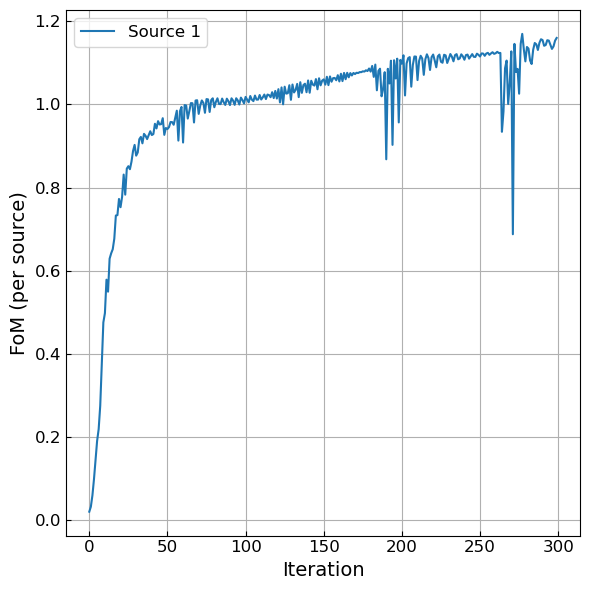

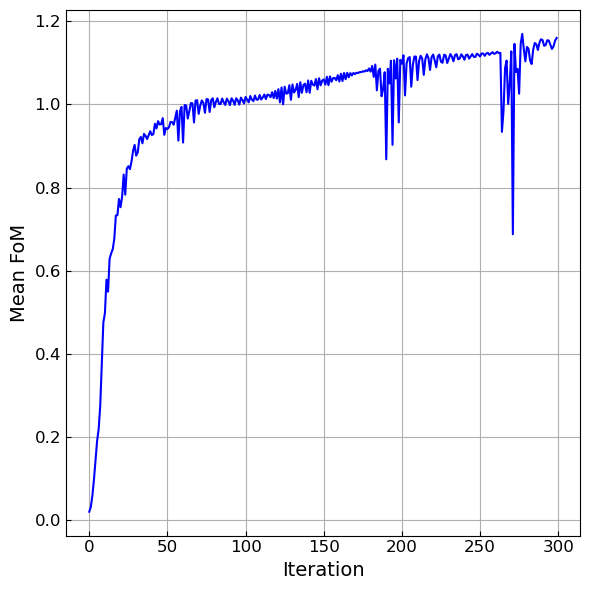

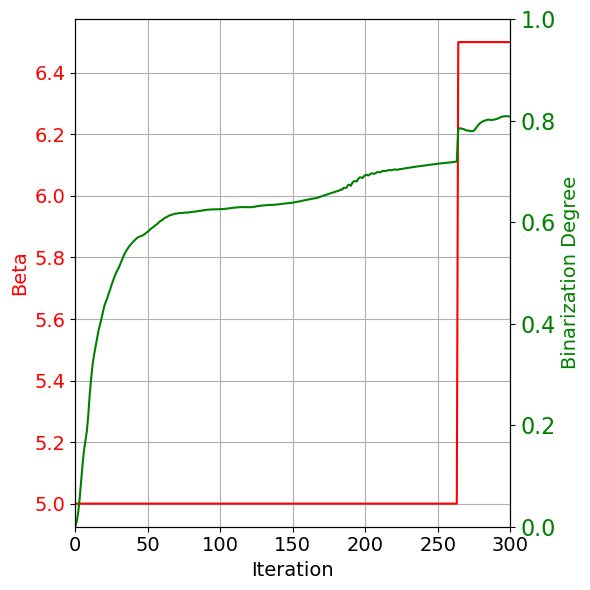

In [113]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom, 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Mean FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

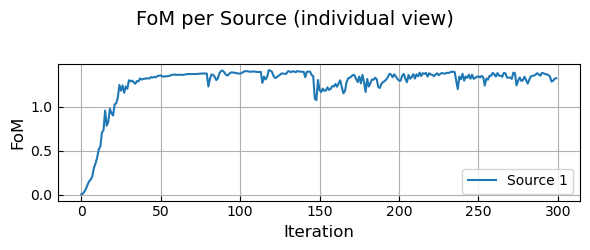

In [57]:
num_sources = evaluation_array.shape[1]

# subplot 생성: num_sources x 1 구조, squeeze=False로 항상 배열 형태 보장
fig, axs = plt.subplots(num_sources, 1,
                        figsize=(6, 2.5 * num_sources),
                        sharex=True,
                        squeeze=False)

# axs가 2D 배열 (num_sources, 1)이므로 1D로 평탄화
axs = axs.flatten()

# 각 소스별 FoM 그리기
for i in range(num_sources):
    axs[i].plot(iterations,
                evaluation_array[:, i],
                label=f"Source {i+1}",
                color=f"C{i}")
    axs[i].set_ylabel("FoM", fontsize=12)
    axs[i].legend(fontsize=10)
    axs[i].grid(True)
    axs[i].tick_params(labelsize=10, direction='in')

# 맨 아래 subplot에만 x축 레이블 표시
axs[-1].set_xlabel("Iteration", fontsize=12)

# 제목 및 레이아웃 조정
fig.suptitle("FoM per Source (individual view)", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [ ]:
# k = design_variables.weights
# np.savetxt("New_FOM_final.txt", k) 

In [127]:
design_load = np.loadtxt("New_FOM_final.txt")
for i in range(len(sources)):
    opt_list[i].update_design([design_load])

Plotting geometry for Source 1


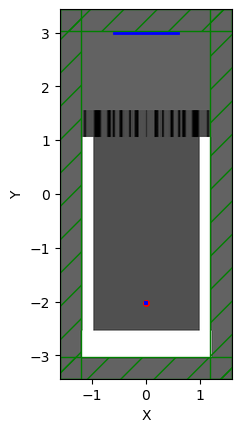

In [128]:
# offset = 0.25
# flux_size = 0.5

offset = 0.01
flux_size = 0.02

mn_size = 1.2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size = mp.Vector3(mn_size, 0)

input_flux_list = []
output_flux_list = []
dft_fields_list = []

for i in range(len(sources)):
    

    sim_i = opt_list[i].sim
    source_i = sources[i]

    input_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=source_i.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size),
                      ),
        mp.FluxRegion(center=source_i.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=source_i.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0),
                      ),
        mp.FluxRegion(center=source_i.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    output_flux = sim_i.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # dft_fields = sim_i.add_dft_fields(
    #     [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
    #     fcen, 0, 1,
    #     center=monitor_position_y,
    #     size=monitor_size,
    #     yee_grid=True
    # )
    # dft_fields_list.append(dft_fields)

    print(f"Plotting geometry for Source {i+1}")
    opt_list[i].plot2D()
    plt.show()


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1


/home/min/miniconda3/envs/mp/lib/python3.9/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


📊 Plotting 2D Ez for Source 1


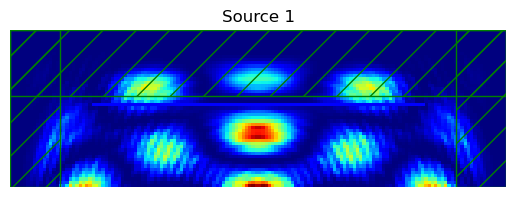

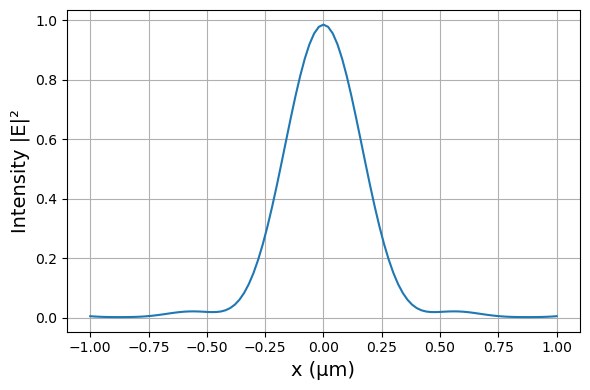


🔍 Source 1
  Input  flux : 0.585392
  Output flux : 0.373702
  EQE (%)     : 63.84 %

=== Summary EQE per source ===
Source 1: EQE = 63.84 %


In [129]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.25
flux_size = 0.5
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []
m = mp.Vector3(0, center_y_monitor_position-2/resolution)
# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, df, nfreq,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, df, nfreq,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, df, nfreq,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        # until_after_sources=mp.stop_when_fields_decayed(
        #     10/df, mp.Ez, m, 1e-3
        # )
        until_after_sources=mp.stop_when_dft_decayed()
        # until=300

    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.abs(x)**2,
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.abs(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %") 

<Axes: xlabel='X', ylabel='Y'>

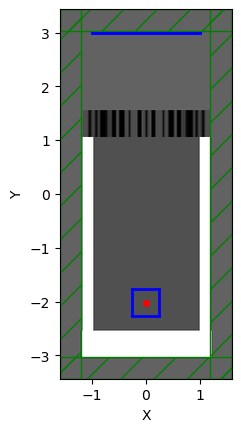

In [23]:
sims[0].plot2D()

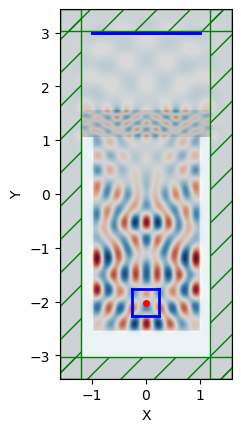

In [33]:
opt_list[0].plot2D(fields=mp.Ez)


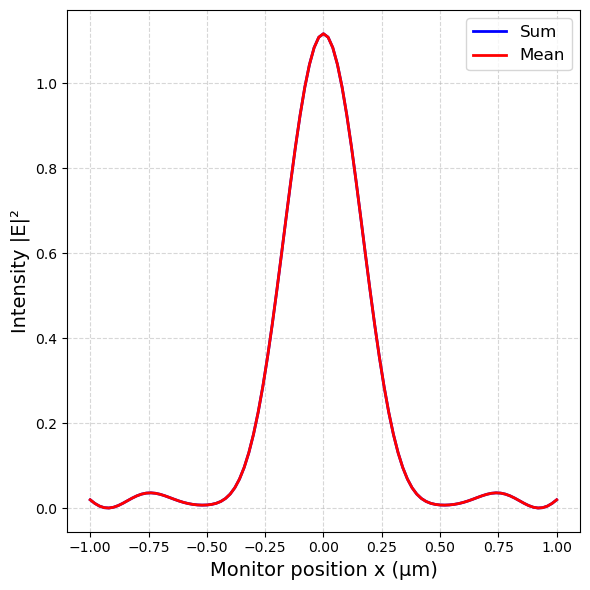

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# === 0) I_profiles 수집용 리스트 초기화 ===
I_profiles = []

# === 1) 각 sim에서 1D intensity 프로파일 계산 & 저장 ===
for sim, dft in zip(sims, dft_fields_list):
    # (이미 sim.run(...) 이 완료된 상태여야 합니다)
    E_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))  # 1D 배열 
    I = E_line**2                              # intensity
    I_profiles.append(I)

# === 2) x 좌표 벡터 생성 ===
N = I_profiles[0].size
x = np.linspace(-mn_size/2, mn_size/2, N)

# === 3) 합(sum) 및 평균(mean) 프로파일 계산 ===
I_stack = np.vstack(I_profiles)   # shape = (num_sources, N)
I_sum   = I_stack.sum(axis=0)     # 각 x 위치별 합
I_mean  = I_stack.mean(axis=0)    # 각 x 위치별 평균

# === 4) 한 그래프에 개별·합·평균 모두 그리기 ===
plt.figure(figsize=(6,6))

# (가) 개별 소스 프로파일: 연회색 얇은 선
for I in I_profiles:
    plt.plot(x, I, color='gray', alpha=0.3)

# (나) 합 프로파일: 검정 두꺼운 선
plt.plot(x, I_sum, 'b-', lw=2, label='Sum')

# (다) 평균 프로파일: 빨강 두꺼운 선
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')

plt.xlabel('Monitor position x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


적분 범위: ±0.520 µm → P_total(1차 링까지) = 0.441620


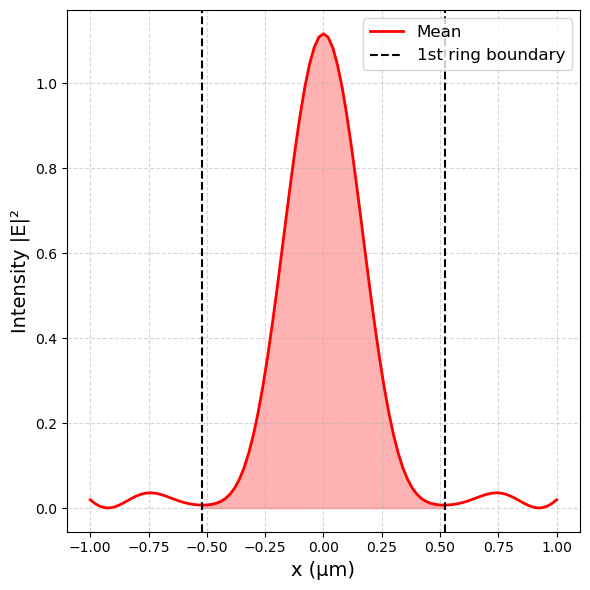

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean  = I_stack.mean(axis=0)   # sum 으로 되어 있던 부분 그대로

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

ring1_idx = minima_idx[0] if len(minima_idx)>0 else None
# ring2_idx = minima_idx[1] if len(minima_idx)>1 else None  # 더 이상 사용 안 함

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
# x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 적분 범위를 1차 링까지로 한정 ---
mask_total = (np.abs(x) <= x_ring1)   # <-- 2차 대신 1차 링까지
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# (원한다면 1차 링 내 세기도 별도 계산)
mask1 = mask_total
P1     = P_total
eff1   = 100.0  # P1 / P_total * 100 이므로 항상 100%

# --- 4) 결과 출력 ---
print(f"적분 범위: ±{x_ring1:.3f} µm → P_total(1차 링까지) = {P_total:.6f}")
# print(f"1차 링 내 세기 P1 = {P1:.6f}, 효율 = {eff1:.2f}%")

# --- 5) 시각화 ---
plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring1, ls='--', color='k', label='1st ring boundary')
plt.axvline(+x_ring1, ls='--', color='k')

plt.fill_between(x, I_mean, where=mask_total,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


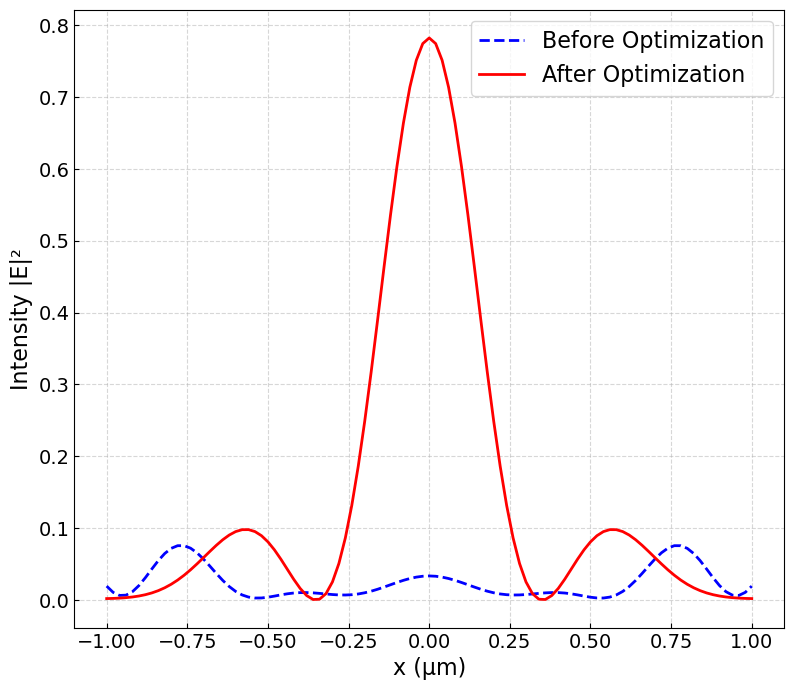

Average efficiency (Current/Saved mean): 1007.29%


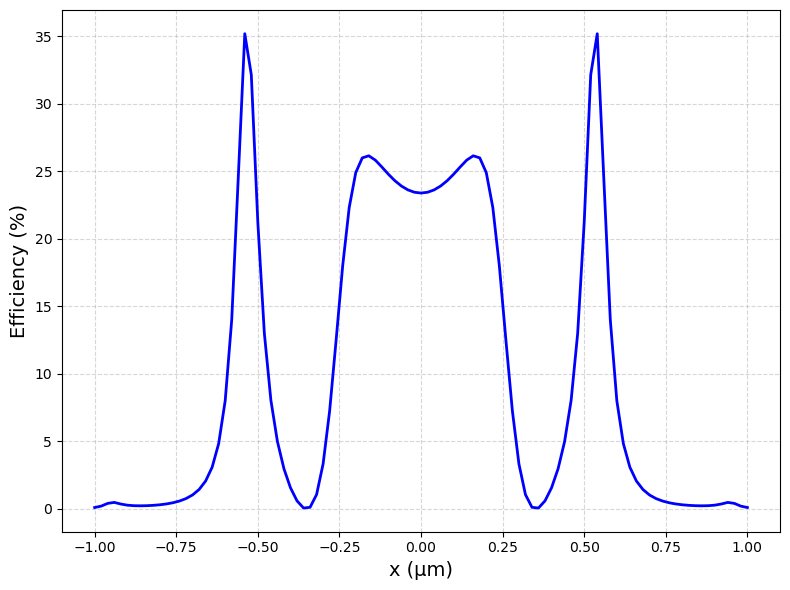

In [63]:
import numpy as np
import matplotlib.pyplot as plt

file_path = '/home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt'

data = np.loadtxt(file_path)
x_loaded, I_sum_loaded, I_mean_loaded = data.T
plt.figure(figsize=(8,7))

plt.plot(x_loaded, I_mean_loaded, 'b--', lw=2, label='Before Optimization')

plt.plot(x, I_mean, 'r-', lw=2, label='After Optimization')

plt.xlabel('x (µm)', fontsize=16)
plt.ylabel('Intensity |E|²', fontsize=16)
plt.legend(fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tick_params(direction = 'in')
plt.show()

eff_line = (I_mean / I_mean_loaded) 

avg_eff = np.mean(eff_line)* 100
print(f"Average efficiency (Current/Saved mean): {avg_eff:.2f}%")

plt.figure(figsize=(8,6))
plt.plot(x_loaded, eff_line, 'b-', lw=2)
plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Efficiency (%)', fontsize=14)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

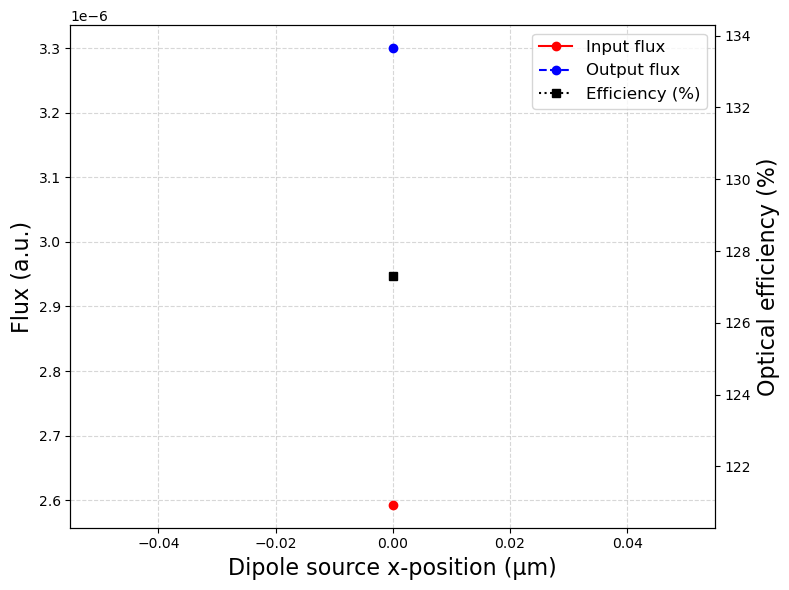

In [123]:
positions      = [src.center.x for src in sources]
input_values   = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values  = [mp.get_fluxes(f)[0] for f in output_flux_list]
percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

fig, ax1 = plt.subplots(figsize=(8,6))

# 왼쪽 축에 입력/출력 flux
ax1.plot(positions, input_values,  'ro-', label='Input flux')
ax1.plot(positions, output_values, 'bo--', label='Output flux')
ax1.set_xlabel('Dipole source x-position (µm)', fontsize=16)
ax1.set_ylabel('Flux (a.u.)',              fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', ls='--', alpha=0.5)

# 오른쪽 축에 효율
ax2 = ax1.twinx()
ax2.plot(positions, percent_values, 'ks:', label='Efficiency (%)')
ax2.set_ylabel('Optical efficiency (%)', fontsize=16, color='k')
ax2.tick_params(axis='y', labelcolor='k')

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

plt.tight_layout()
plt.show()


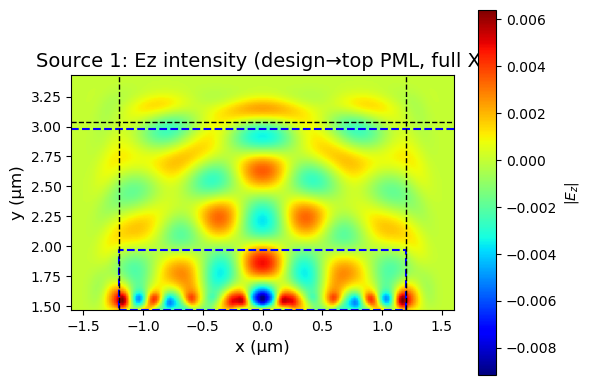

In [30]:
# 1) Y 범위: 디자인 영역 바닥→상단 PML 끝 (기존과 동일)
y_design_bot = center_y_design - design_region_height/2
y_start     = y_design_bot
y_end       = Sy/2

# 2) X 범위: 셀 전체 폭 (PML 포함)
x_start = -Sx/2
x_end   =  Sx/2

# 3) 해상도 벡터 재계산
nx   = int(resolution * Sx) + 1
x_res = np.linspace(x_start, x_end, nx)

ny   = int(resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

# 4) Volume 정의: X=Sx, Y=y_end–y_start
vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=mp.Vector3(Sx, y_end - y_start, 0)
)

# 5) 플롯 루프
# 5) 플롯 루프
for i in range(num_sources):
    Ez_slice = opt_list[i].sim.get_array(mp.Ez, vol).T
    I = np.real(Ez_slice)
    
    # I_max = np.max(np.real(Ez_slice))
    # I = np.real(Ez_slice)/I_max

    plt.figure(figsize=(6,4))
    plt.imshow(
        I,
        origin='lower',
        extent=[x_start, x_end, y_start, y_end],
        aspect='equal',
        cmap='jet'
    )
    plt.colorbar(label=r'$|E_z|$')
    plt.title(f"Source {i+1}: Ez intensity (design→top PML, full X)", fontsize=14)
    plt.xlabel('x (µm)', fontsize=12)
    plt.ylabel('y (µm)', fontsize=12)

    # — 디자인 영역 표시 —
    x0, x1 = -design_region_width/2, design_region_width/2
    y0 = y_design_bot
    y1 = y_design_bot + design_region_height
    plt.plot(
        [x0, x1, x1, x0, x0],
        [y0, y0, y1, y1, y0],
        'b--', lw=1.5, label='Design region'
    )

    # — 모니터 평면 표시 —
    plt.axhline(center_y_monitor_position, color='blue',
                ls='--', lw=1.5, label='Monitor plane')

    # — PML 경계 표시 (점선) —
    # 수평 PML 경계
    # plt.axhline(y_start + tpml,          color='yellow', ls='--', lw=1, label='Bottom PML end')
    plt.axhline(y_end   - tpml,          color='k', ls='--', lw=1, label='Top PML start')
    # 수직 PML 경계
    plt.axvline(x_start + tpml,          color='k', ls='--', lw=1, label='Left PML end')
    plt.axvline(x_end   - tpml,          color='k', ls='--', lw=1, label='Right PML start')

    # — 축범위 고정 —
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)

    # plt.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    plt.show()



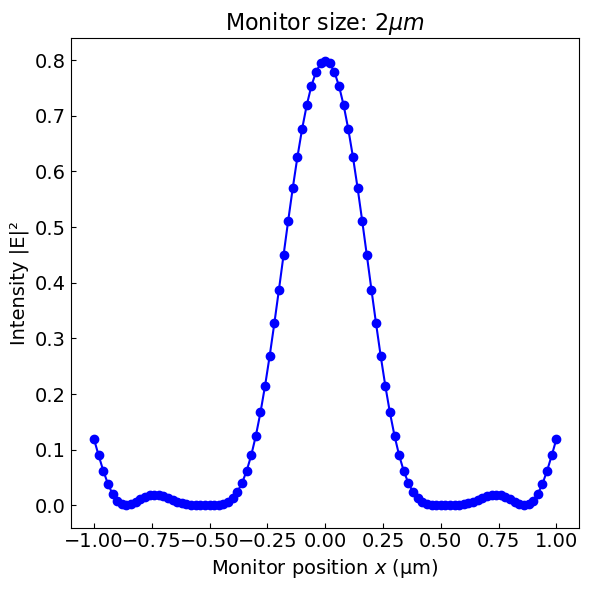

In [31]:
external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(x, I, 'bo-')


plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
# plt.ylabel('phase',       fontsize=14)
plt.title(r'Monitor size: $2\mu m$', fontsize=16)
plt.tick_params(direction = 'in')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

nx = int(design_region_resolution * design_region_width) + 1
x_res = np.linspace(-design_region_width/2,
                     design_region_width/2,
                     nx)

y_start = center_y_design + design_region_height/2
y_end   = center_y_monitor_position + 1/fcen
ny = int(design_region_resolution * (y_end - y_start)) + 1
y_res = np.linspace(y_start, y_end, ny)

vol = mp.Volume(
    center=mp.Vector3(0, (y_start + y_end)/2, 0),
    size=  mp.Vector3(design_region_width,
                      y_end - y_start,
                      0)
)
Ez_slice = opt_list[2].sim.get_array(mp.Ez, vol).T   # shape == (ny, nx)

plt.figure(figsize=(8,4))
plt.imshow(
    np.abs(Ez_slice),      # (ny, nx)
    origin='lower',
    extent=[x_res.min(), x_res.max(), y_res.min(), y_res.max()],
    aspect='equal',
    cmap='jet'
)

cbar = plt.colorbar()
cbar.set_label(r'$|E_z|$', fontsize=14)
cbar.ax.tick_params(labelsize=14)

# plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
# plt.ylabel('Height $y$ (µm)',           fontsize=14)
# plt.title(r'Monitor size: $2\ \mu m$',   fontsize=16)

# 틱 폰트 크기 및 방향 맞추기
plt.tick_params(direction='in', labelsize=14)
# plt.tight_layout()
plt.axis('off')
plt.show()

#### 소스 위치나 모니터 위치, 구조물 등등)

IndexError: list index out of range

In [77]:
input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
print("Input되고 있는 flux : ", input)

NameError: name 'input_flux_list' is not defined

In [ ]:
import numpy as np

I = np.real(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

center_idx = np.argmax(I)
# 간단히 for문으로
for i in range(center_idx+1, N-1):
    if I[i] < I[i-1] and I[i] < I[i+1]:
        x_limit = abs(x[i])
        break
else:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")

x_min, x_max = -x_limit, x_limit

mask = (x >= x_min) & (x <= x_max)

x_slice = x[mask]
I_slice = I[mask]

dx = x[1] - x[0]
flux_slice = np.sum(I_slice) * dx   

input = np.mean([mp.get_fluxes(flux)[0] for flux in input_flux_list])
output = np.array(mp.get_fluxes(out_flux))[0]

print("Input flux :", input)
print("Output flux :", output)
print(f"±{x_limit:.3f} µm 구간 integrated intensity: {flux_slice}")

optical_eqe = flux_slice/input * 100
print("1차 ring까지의 Optical EQE :", optical_eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'

In [26]:
import numpy as np

# 1) 강도 계산
I = np.abs(external_field_array)**2
N = len(I)
W = mn_size
x = np.linspace(-W/2, W/2, N)
center_idx = np.argmax(I)

# 2) 첫 번째 링 경계: 미분으로 valley 찾기
dI = np.diff(I)
valleys = np.where((dI[:-1] < 0) & (dI[1:] > 0))[0] + 1
valleys = valleys[valleys > center_idx]
if valleys.size == 0:
    raise RuntimeError("1차 링 경계를 찾을 수 없음")
idx_valley = valleys[0]
x_limit = abs(x[idx_valley])

# 3) 적분 구간 설정
mask = (x >= -x_limit) & (x <= x_limit)
dx = x[1] - x[0]
flux_slice = np.sum(I[mask]) * dx

# 4) Flux 모니터 값
input_flux  = np.array(mp.get_fluxes(input_flux))[0]
output_flux = np.array(mp.get_fluxes(out_flux))[0]

# 5) Optical EQE 계산: 출력 flux 비율을 사용
optical_eqe = output_flux / input_flux * 100

print(f"±{x_limit:.3f} µm 구간 intensity 적분: {flux_slice:.4f}")
print(f"모니터 기반 Optical EQE: {optical_eqe:.2f}%")


±0.320 µm 구간 intensity 적분: 1.0391
모니터 기반 Optical EQE: 75.64%


In [287]:
eqe = mp.get_fluxes(out_flux)[0]/mp.get_fluxes(input_flux)[0]*100
    
print("Input flux :", mp.get_fluxes(input_flux)[0])
print("Output flux :", mp.get_fluxes(out_flux)[0])
print("EQE(%) :", eqe,"%")

AttributeError: 'numpy.float64' object has no attribute 'flux'